# Modulation Classification
### Group 38: Kartik Kulgod, Young Li, Parker Martin

## Import Statements

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

## Define Neural Network

In [ ]:
class ModulationClassifier(torch.nn.Module):
    def __init__(self, num_classes=11):
        super(ModulationClassifier, self).__init__()
        
        # Treating input as 2x128 image with 1 channel (depth 1)
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(1,3), padding=(0,2)), torch.nn.BatchNorm2d(256))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2,3), padding=(0,2)), torch.nn.BatchNorm2d(80))
        self.classifier = torch.nn.Sequential(torch.nn.Linear(in_features=10560, out_features=256),
                                              torch.nn.ReLU(True),
                                             torch.nn.Linear(in_features=256, out_features=11))

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y2 = F.relu(self.conv2(y1))
        y3 = torch.flatten(y2, 1)
        y4 = self.classifier(y3)
        return y4

## Setup Input Data

### Read data from file

In [2]:
fname = 'RML2016.10a_dict.pkl'
f = open(fname,'rb')

input_data_dict = pickle.load(f, encoding='latin1')

input_data_dict_keys = sorted(input_data_dict.keys())

modulation_types    = [input_data_dict_keys[i*20][0] for i in range(0,11)]
snr_types           = [input_data_dict_keys[i][1] for i in range(0,20)]

print(modulation_types)
print(snr_types)

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## Visualize Data

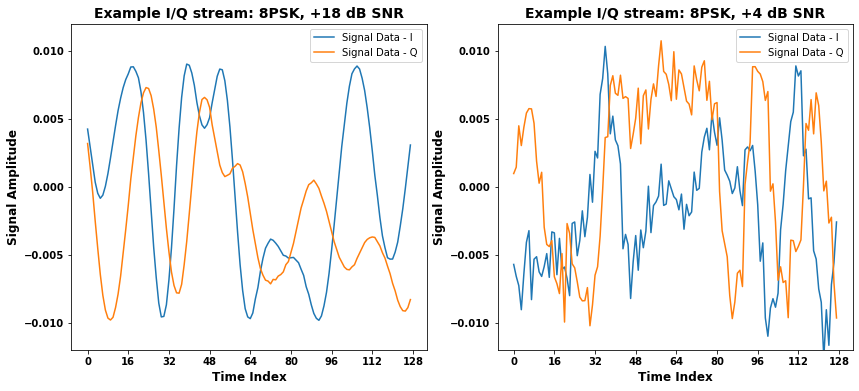

In [3]:
# Plot example I/Q timeseries
plt.figure(figsize=(14,6))

# Plot data 0 (out of range 0:999) of 8PSK, SNR +18
i_data = input_data_dict[('8PSK',18)][0][0]
q_data = input_data_dict[('8PSK',18)][0][1]

#### Fill in plot #####
plt.subplot(121)
plt.title('Example I/Q stream: 8PSK, +18 dB SNR', fontweight='bold', fontsize=14);
plt.plot(range(0,128), i_data, range(0,128), q_data);
plt.xlabel('Time Index', fontsize=12, fontweight='bold');
plt.xticks(np.arange(0, 129, step=16), fontweight='bold', fontsize=10);
plt.ylabel('Signal Amplitude', fontsize=12, fontweight='bold');
plt.yticks(fontweight='bold', fontsize=10);
plt.legend(('Signal Data - I','Signal Data - Q'), fontsize=10, loc=1);
plt.ylim(-.012, .012);

# Plot data 0 (out of range 0:999) of 8PSK, SNR +4
i_data = input_data_dict[('8PSK',4)][0][0]
q_data = input_data_dict[('8PSK',4)][0][1]

#### Fill in plot #####
plt.subplot(122)
plt.title('Example I/Q stream: 8PSK, +4 dB SNR', fontweight='bold', fontsize=14);
plt.plot(range(0,128), i_data, range(0,128), q_data);
plt.xlabel('Time Index', fontsize=12, fontweight='bold');
plt.xticks(np.arange(0, 129, step=16), fontweight='bold', fontsize=10);
plt.ylabel('Signal Amplitude', fontsize=12, fontweight='bold');
plt.yticks(fontweight='bold', fontsize=10);
plt.legend(('Signal Data - I','Signal Data - Q'), fontsize=10, loc=1);
plt.ylim(-.012, .012);
plt.show();

## Create Pytorch Dataset

In [4]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, X,Y,Z, transform=None):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        rX, rY, rZ = torch.unsqueeze(torch.from_numpy(self.X[idx]),dim=0).float(), torch.tensor(self.Y[idx]), torch.tensor(self.Z[idx])
        if(self.transform):
            rX, rY, rZ = self.transform(self.X[idx]),torch.tensor(self.Y[idx]),torch.tensor(self.Z[idx])
            
        return rX, rY, rZ

## Train with only positive SNR values

### Create data arrays

In [5]:
image_psnr = []
modulation_psnr = []
snr_psnr = []

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types[10:]:
        image_psnr.extend(input_data_dict[(m,s)])
        modulation_psnr.extend([m_cnt for _ in range(0,1000)])
        snr_psnr.extend([s for _ in range(0,1000)])
        
image_nsnr = []
modulation_nsnr = []
snr_nsnr = []

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types[:10]:
        image_nsnr.extend(input_data_dict[(m,s)])
        modulation_nsnr.extend([m_cnt for _ in range(0,1000)])
        snr_nsnr.extend([s for _ in range(0,1000)])
        
image_asnr = []
image_asnr.extend(image_psnr)
image_asnr.extend(image_nsnr)
modulation_asnr = []
modulation_asnr.extend(modulation_psnr)
modulation_asnr.extend(modulation_nsnr)
snr_asnr = []
snr_asnr.extend(snr_psnr)
snr_asnr.extend(snr_nsnr)
        
        
image_psnr = np.array(image_psnr)
modulation_psnr = np.array(modulation_psnr)
snr_psnr = np.array(snr_psnr)

image_nsnr = np.array(image_nsnr)
modulation_nsnr = np.array(modulation_nsnr)
snr_nsnr = np.array(snr_nsnr)

image_asnr = np.array(image_asnr)
modulation_asnr = np.array(modulation_asnr)
snr_asnr = np.array(snr_asnr)

print(len(image_asnr))

220000


# Create Dataloaders RUN ALL UP TO THIS ONE

In [6]:
transformed_dataset_psnr = myDataset(image_psnr, modulation_psnr, snr_psnr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))
transformed_dataset_nsnr = myDataset(image_nsnr, modulation_nsnr, snr_nsnr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))
transformed_dataset_asnr = myDataset(image_asnr, modulation_asnr, snr_asnr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))

l = list(range(0, 110000))
np.random.shuffle(l)
split = 0.5
train_indices_psnr, test_indices_psnr = l[:int(split*110000)],l[int(split*110000):]
test_indices_nsnr = l

l = list(range(0, 220000))
np.random.shuffle(l)
split = 0.5
train_indices_asnr, test_indices_asnr = l[:int(split*220000)],l[int(split*220000):]

train_sampler_psnr = torch.utils.data.SubsetRandomSampler(train_indices_psnr)
test_sampler_psnr  = torch.utils.data.SubsetRandomSampler(test_indices_psnr)
test_sampler_nsnr  = torch.utils.data.SubsetRandomSampler(test_indices_nsnr)

train_sampler_asnr = torch.utils.data.SubsetRandomSampler(train_indices_asnr)
test_sampler_asnr  = torch.utils.data.SubsetRandomSampler(test_indices_asnr)
#PSNR
trainloader_psnr   = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler_psnr, pin_memory=True)
testloader_psnr    = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler_psnr, pin_memory=True)
testloader_nsnr    = torch.utils.data.DataLoader(transformed_dataset_nsnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler_nsnr, pin_memory=True)

#ASNR
trainloader_asnr   = torch.utils.data.DataLoader(transformed_dataset_asnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler_asnr, pin_memory=True)
testloader_asnr    = torch.utils.data.DataLoader(transformed_dataset_asnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler_asnr, pin_memory=True)

## Intialize NN, Optimizer, Loss function

In [ ]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

print(net)
for name, param in net.named_parameters():
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

## Train NN

In [ ]:
num_epochs = 50
epoch_loss_array = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    
    for i, data in enumerate(trainloader_psnr):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    print('Epoch {:d}, Training Loss {:f}'.format(epoch,running_loss/len(trainloader_psnr)))
    epoch_loss_array.append(running_loss/len(trainloader_psnr))

print('Finished Training')

In [ ]:
plt.plot(list(range(0,num_epochs)), epoch_loss_array)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.show()

## Test NN

In [ ]:
PATH = './temp_model_psnr.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader_psnr):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

for i,data in enumerate(testloader_nsnr):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))

In [ ]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
        print('SNR {:s} Accuracy {:f} %'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

In [ ]:
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy')
plt.title('Accuracy vs SNR')
plt.show()

## Train with all SNR values to see accuracy.  

## Intialize NN, Optimizer, Loss function

In [ ]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(len(transformed_dataset_psnr))
print(len(trainloader_psnr))

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

print(net)
for name, param in net.named_parameters():
    #if param.requires_grad:
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

## Train NN

In [ ]:
num_epochs = 50
epoch_loss_array = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    
    for i, data in enumerate(trainloader_asnr):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    print(running_loss/len(trainloader_asnr))
    epoch_loss_array.append(running_loss/len(trainloader_asnr))

print('Finished Training')

In [ ]:
plt.plot(list(range(0,num_epochs)), epoch_loss_array)
plt.xlabel('Epochs'
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epochs')
plt.show()

## Test NN

In [ ]:
PATH = './temp_model_asnr.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader_asnr):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))

In [ ]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

In [ ]:
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy')
plt.title('Accuracy vs SNR')
plt.show()

### Above we have discussed that having -SNR values in our model will hinder our accuracy and we have shown that that is true.


### Now, lets try to setup a validation set and do some hyperparameter tuning.


### Define some data loaders

In [ ]:
dataset_len = 110000
l = list(range(0, dataset_len))
np.random.shuffle(l)

split = 0.7
train_indices, test_indices = l[:int(split*dataset_len)], l[int(split*dataset_len):]

valsplit = 0.5
test_indices, val_indices = test_indices[:int(valsplit*len(test_indices))], test_indices[int(valsplit*len(test_indices)):]

print(len(train_indices), len(test_indices),len(val_indices))

train_sampler=torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler=torch.utils.data.SubsetRandomSampler(test_indices)
val_sampler=torch.utils.data.SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler, pin_memory=True)
valloader   = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=val_sampler, pin_memory=True)
testloader1 = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler, pin_memory=True)
testloader2 = torch.utils.data.DataLoader(transformed_dataset_nsnr, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

## Intialize NN, Optimizer, Loss function

In [ ]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

print(net)
for name, param in net.named_parameters():
    #if param.requires_grad:
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

## Train NN RUN VALIDATION_FUNCTION CODE

In [7]:
def validation_function(net, criterion):
    PATH = './temp_model_val.pth'
    torch.save(net.state_dict(), PATH) 

    model1 = ModulationClassifier()
    model1.to(device)
    model1.load_state_dict(torch.load(PATH))
    
    val_loss = 0
    total = 0
    model1.eval()
    for i, data in enumerate(valloader):
        xv, yv, zv = data
        xv, yv, zv = xv.to(device), yv.to(device), zv.to(device)

        yv_pred = model1.forward(xv)
        batchv_loss = criterion(yv_pred, yv.long())
        val_loss += batchv_loss.item()

        total += 128
        
    #print(val_loss)
        
    return val_loss

In [ ]:
num_epochs = 25
epoch_loss_array = np.zeros(num_epochs)

historyEpoch = []
historyLoss = []
historyValLoss = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    correct_test = 0
    historyEpoch.append(epoch)
    
    for i, data in enumerate(trainloader):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        correct_test += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        #print(y_pred)
        #print(loss.item())
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    valloss = validation_function(net, criterion)
    print("Epoch #", epoch, 'Correct:', correct_test,"Loss: ", running_loss/len(trainloader), 'Val Loss', valloss/len(valloader))
    historyLoss.append(running_loss/len(trainloader))
    historyValLoss.append(valloss/len(valloader))

print('Finished Training')
plt.show()

In [ ]:
plt.figure()
plt.title('Training performance')
plt.plot(historyEpoch, historyLoss, 'b.-',label='train loss')
plt.plot(historyEpoch, historyValLoss,'r.-', label='val_error')
plt.legend()

## Test NN

In [ ]:
PATH = './temp_model_new.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader1):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

for i,data in enumerate(testloader2):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size

print('%d %d Accuracy of the network on the test images: %f %%' % (correct, total,
    100 * correct / total))

In [ ]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

In [ ]:
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy')
plt.title('Accuracy vs SNR')
plt.show()

### Add dropout layer NOW EVERYTHING BELOW CAN BE RAN
Start by adding 50% dropout after the two convolutional layers.

In [8]:
class ModulationClassifier(torch.nn.Module):
    def __init__(self, num_classes=11):
        super(ModulationClassifier, self).__init__()
        
        # Treating input as 2x128 image with 1 channel (depth 1)
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(1,3), padding=(0,2)), torch.nn.BatchNorm2d(256))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2,3), padding=(0,2)), torch.nn.BatchNorm2d(80))
        self.drop1 = torch.nn.Dropout(0.50)
        self.classifier = torch.nn.Sequential(torch.nn.Linear(in_features=10560, out_features=256),
                                              torch.nn.ReLU(True),
                                             torch.nn.Linear(in_features=256, out_features=11))

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y2 = self.drop1(y1)
        y3 = F.relu(self.conv2(y2))
        y4 = self.drop1(y3)
        y5 = torch.flatten(y4, 1)
        y6 = self.drop1(y5)
        y7 = self.classifier(y6)
        return y7

# These next couple of boxes are going to be dedicated to hyperparameter tuning. 
Set up same dataloaders.

In [9]:
dataset_len = 110000
l = list(range(0, dataset_len))
np.random.shuffle(l)

split = 0.7
train_indices, test_indices = l[:int(split*dataset_len)], l[int(split*dataset_len):]

valsplit = 0.5
test_indices, val_indices = test_indices[:int(valsplit*len(test_indices))], test_indices[int(valsplit*len(test_indices)):]

print(len(train_indices), len(test_indices),len(val_indices))

train_sampler=torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler=torch.utils.data.SubsetRandomSampler(test_indices)
val_sampler=torch.utils.data.SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler, pin_memory=True)
valloader   = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=val_sampler, pin_memory=True)
testloader1 = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler, pin_memory=True)
testloader2 = torch.utils.data.DataLoader(transformed_dataset_nsnr, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

77000 16500 16500


In [10]:
net = ModulationClassifier()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

print(net)
for name, param in net.named_parameters():
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop1): Dropout(p=0.5, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                    

In [11]:
num_epochs = 100
epoch_loss_array = np.zeros(num_epochs)

historyEpoch = []
historyLoss = []
historyValLoss = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    correct_test = 0
    historyEpoch.append(epoch)
    
    for i, data in enumerate(trainloader):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        correct_test += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        #print(y_pred)
        #print(loss.item())
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    valloss = validation_function(net, criterion)
    print("Epoch #", epoch, 'Correct:', correct_test,"Loss: ", running_loss/len(trainloader), 'Val Loss', valloss/len(valloader))
    historyLoss.append(running_loss/len(trainloader))
    historyValLoss.append(valloss/len(valloader))

print('Finished Training')
plt.show()

Epoch # 0 Correct: 30499 Loss:  1.5943285445636293 Val Loss 1.00028319460477
Epoch # 1 Correct: 47575 Loss:  0.9013040694485471 Val Loss 0.721643047739369
Epoch # 2 Correct: 51821 Loss:  0.7301494416802429 Val Loss 0.6067452774953472
Epoch # 3 Correct: 53714 Loss:  0.6527953310761341 Val Loss 0.5603235437888507
Epoch # 4 Correct: 54688 Loss:  0.6143829128967964 Val Loss 0.5245523882466693
Epoch # 5 Correct: 55630 Loss:  0.5799188031211644 Val Loss 0.5113881188769673
Epoch # 6 Correct: 56510 Loss:  0.5554619665161715 Val Loss 0.48573420098585673
Epoch # 7 Correct: 57359 Loss:  0.5310589136475344 Val Loss 0.47098679805910865
Epoch # 8 Correct: 57756 Loss:  0.5176682244008561 Val Loss 0.46908725855886474
Epoch # 9 Correct: 58156 Loss:  0.5055319630228404 Val Loss 0.45293195765147837
Epoch # 10 Correct: 58439 Loss:  0.4954644643092076 Val Loss 0.4403930606768113
Epoch # 11 Correct: 58718 Loss:  0.48477794729990026 Val Loss 0.4327695226484491
Epoch # 12 Correct: 59327 Loss:  0.4744787345395

## Plot

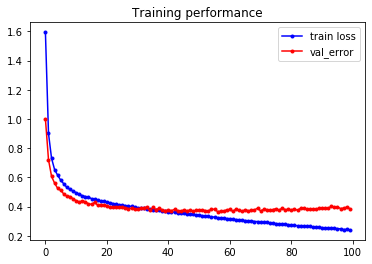

In [12]:
plt.figure()
plt.title('Training performance')
plt.plot(historyEpoch, historyLoss, 'b.-',label='train loss')
plt.plot(historyEpoch, historyValLoss,'r.-', label='val_error')
plt.legend()

## Test NN (This set has dropout) & Collect Confusion Matrix Data

In [14]:
PATH = './temp_model_new.pth'
torch.save(net.state_dict(), PATH) 

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

overall_correct = 0
overall_total = 0

# Helper variables
num_mods = len(modulation_types)
testloader1_10pct = int(0.1*len(testloader1))
testloader2_10pct = int(0.1*len(testloader2))


# snr_accuracy dictionary has keys that are SNRs and values that are [2,1] matrices.
# First element = number of correct 
snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]

    
# confusion_totals dictionary has keys that are SNRs and values that are 11x11 matrices. 
# Row = true modulation, Column = model-predicted modulation.  Matrix elements are counts of occurance. 
# Example: confusion_totals['8'][3,2] = 4 would mean that there were 4 data samples at +8 dB SNR 
#          of modulation BPSK that were misclassified by the model as AM-SSB.
# confusion_percentages will be the same as confusion_totals, but normalized by true modulation.
confusion_totals = dict()
confusion_pcts = dict()
for i in range(-20,20,2):
    k = str(i)
    confusion_totals[k] = np.zeros((num_mods,num_mods))
    confusion_pcts[k] = np.zeros((num_mods,num_mods))

    
# Evaluate and categorize Positive SNR test data by SNR, true modulation, and predicted modulation
model1.eval()
for i,data in enumerate(testloader1):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)
    
    pred_mod = model1.forward(x)
    pred_mod_idx = torch.argmax(pred_mod,dim=1).item()
    true_mod_idx = y.item()
    snr_value = z.item()

    # Track accuracy (overall and per-SNR)
    overall_correct += torch.sum((torch.argmax(pred_mod,dim=1) == y)).item()
    overall_total += 1 #Increase by batch size
    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(pred_mod,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    # Increment appropriate confusion matrix element 
    confusion_totals[str(int(snr_value))][true_mod_idx,pred_mod_idx] += 1
    
    # Print progress
    if (i%testloader1_10pct == 0):
        print("testloader1 (postive SNR) is %.0f%% complete" % (100 * float(i)/len(testloader1)))

print("testloader1 (negative SNR) is complete!\n")
        
    
# Evaluate and categorize Negative SNR test data by SNR, true modulation, and predicted modulation
for i,data in enumerate(testloader2):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)
    
    pred_mod = model1.forward(x)
    pred_mod_idx = torch.argmax(pred_mod,dim=1).item()
    true_mod_idx = y.item()
    snr_value = z.item()

    # Track accuracy (overall and per-SNR)
    overall_correct += torch.sum((torch.argmax(pred_mod,dim=1) == y)).item()
    overall_total += 1 #Increase by batch size
    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(pred_mod,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    # Increment appropriate confusion matrix element 
    confusion_totals[str(int(snr_value))][true_mod_idx,pred_mod_idx] += 1
    
    # Print progress
    if (i%testloader2_10pct == 0):
        print("testloader2 (negative SNR) is %.0f%% complete" % (100 * float(i)/len(testloader2)))

print("testloader2 (postive SNR) is complete!\n")


# Normalize confusion matrix by dividing each matrix element by the sum of the row it lives in.
for i in range(-20,20,2):
    k = str(i)
    for true_mods in range(0,num_mods):
        confusion_pcts[k][true_mods,:] = confusion_totals[k][true_mods,:] / np.sum(confusion_totals[k][true_mods,:])
    
    
# Print overall accuracy (this is not very meaningful since we have many more negative SNR cases)
print('%d %d Accuracy of the network on the test images: %f %%' % (overall_correct, overall_total,
    100 * overall_correct / overall_total))

testloader1 (postive SNR) is 0% complete
testloader1 (postive SNR) is 10% complete
testloader1 (postive SNR) is 20% complete
testloader1 (postive SNR) is 30% complete
testloader1 (postive SNR) is 40% complete
testloader1 (postive SNR) is 50% complete
testloader1 (postive SNR) is 60% complete
testloader1 (postive SNR) is 70% complete
testloader1 (postive SNR) is 80% complete
testloader1 (postive SNR) is 90% complete
testloader1 (negative SNR) is complete!

testloader2 (negative SNR) is 0% complete
testloader2 (negative SNR) is 10% complete
testloader2 (negative SNR) is 20% complete
testloader2 (negative SNR) is 30% complete
testloader2 (negative SNR) is 40% complete
testloader2 (negative SNR) is 50% complete
testloader2 (negative SNR) is 60% complete
testloader2 (negative SNR) is 70% complete
testloader2 (negative SNR) is 80% complete
testloader2 (negative SNR) is 90% complete
testloader2 (postive SNR) is complete!

32023 126500 Accuracy of the network on the test images: 25.314625 %


## Print Array of Model Accuracy per SNR

In [15]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

SNR -20 Accuracy 9.100000
SNR -18 Accuracy 9.100000
SNR -16 Accuracy 9.090909
SNR -14 Accuracy 9.081818
SNR -12 Accuracy 9.090909
SNR -10 Accuracy 9.145455
SNR -8 Accuracy 9.890909
SNR -6 Accuracy 12.363636
SNR -4 Accuracy 26.545455
SNR -2 Accuracy 64.790909
SNR 0 Accuracy 80.116618
SNR 2 Accuracy 81.534772
SNR 4 Accuracy 81.841110
SNR 6 Accuracy 81.238725
SNR 8 Accuracy 81.960313
SNR 10 Accuracy 83.333333
SNR 12 Accuracy 83.516484
SNR 14 Accuracy 82.553191
SNR 16 Accuracy 82.403965
SNR 18 Accuracy 81.077844


## Function for Plotting Confusion Matrixes

In [19]:
# Function for plotting confusion matrixes
def plot_cm(conf_mat, title, filename):
    plt.figure(figsize=(12,8))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontweight='bold', fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(num_mods)
    plt.xticks(tick_marks, modulation_types, rotation=45, fontweight='bold', fontsize=12)
    plt.yticks(tick_marks, modulation_types, fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.ylabel('True Modulation', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Modulation', fontsize=16, fontweight='bold')
    plt.ylim(num_mods - 0.5, -0.5)
    plt.grid(True, color='white')
    plt.savefig(filename,bbox_inches='tight')
    plt.show

## Plot Confusion Matrix for Each SNR

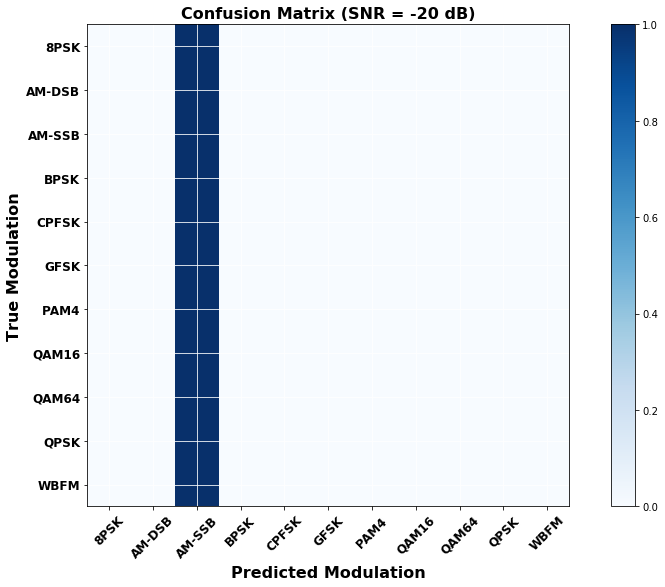

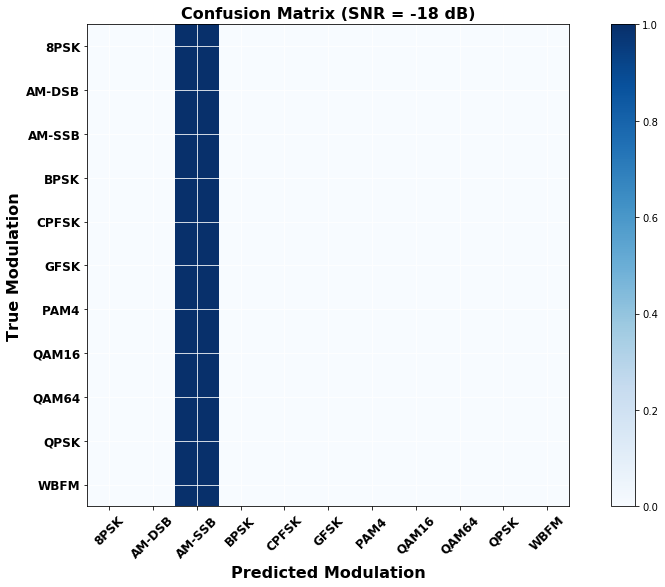

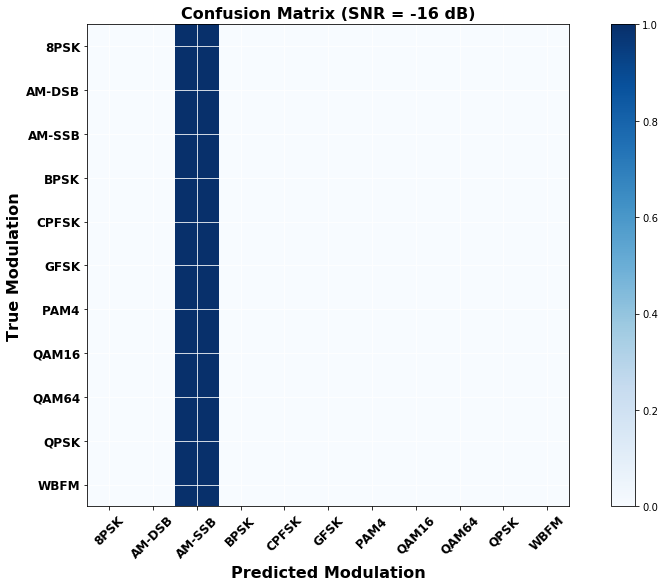

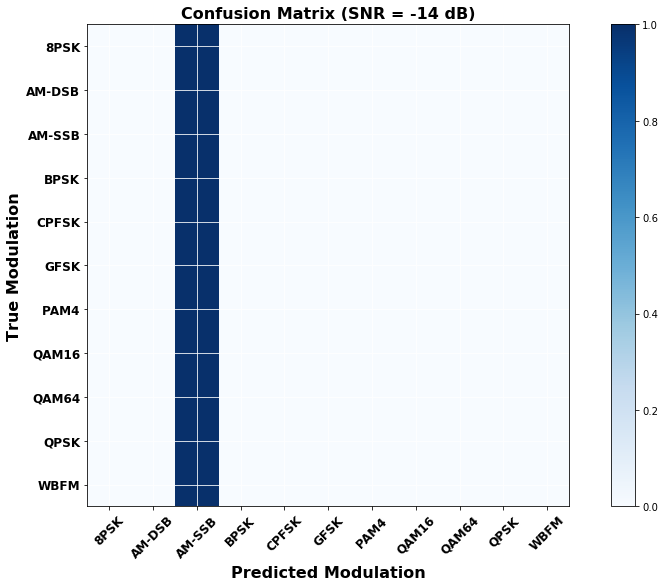

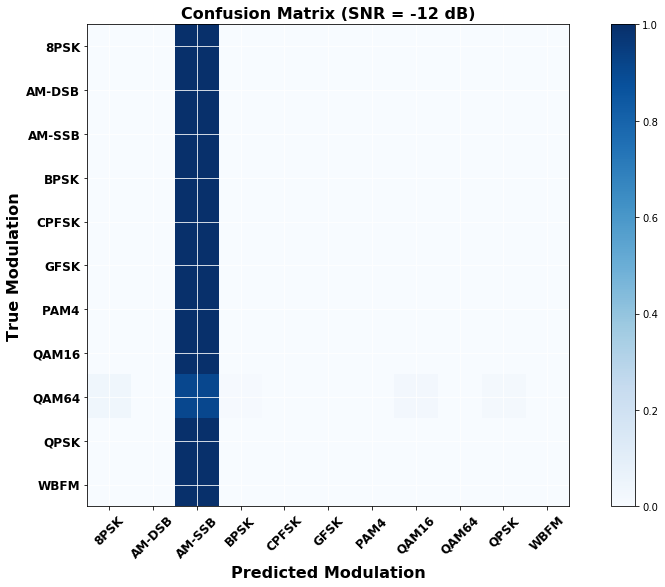

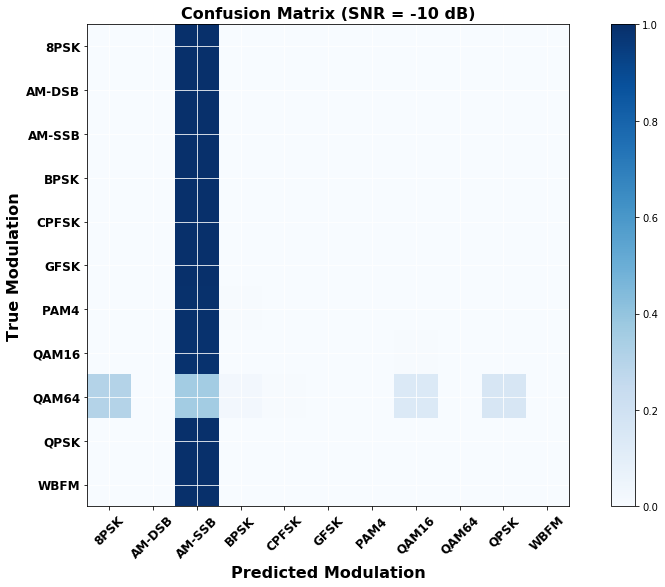

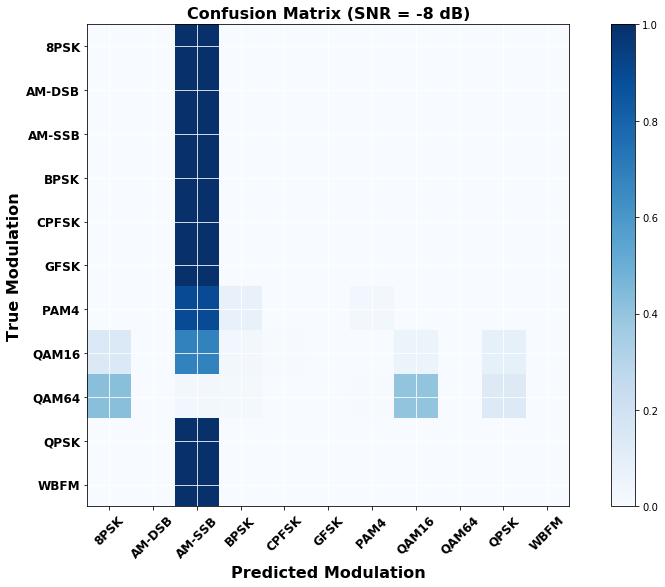

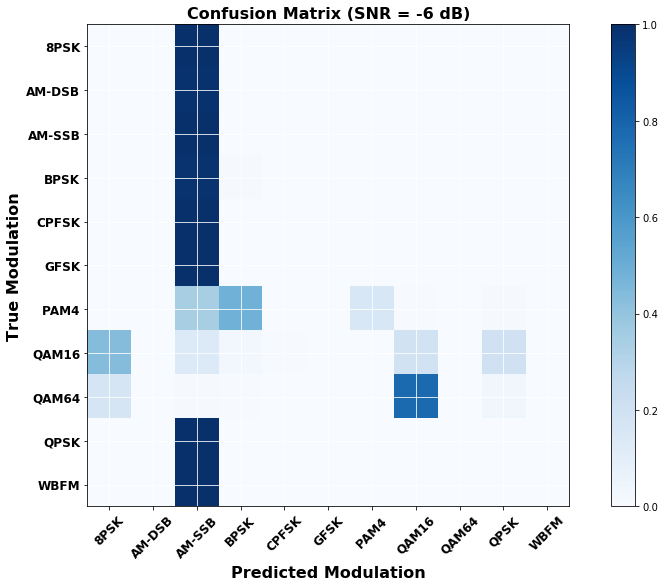

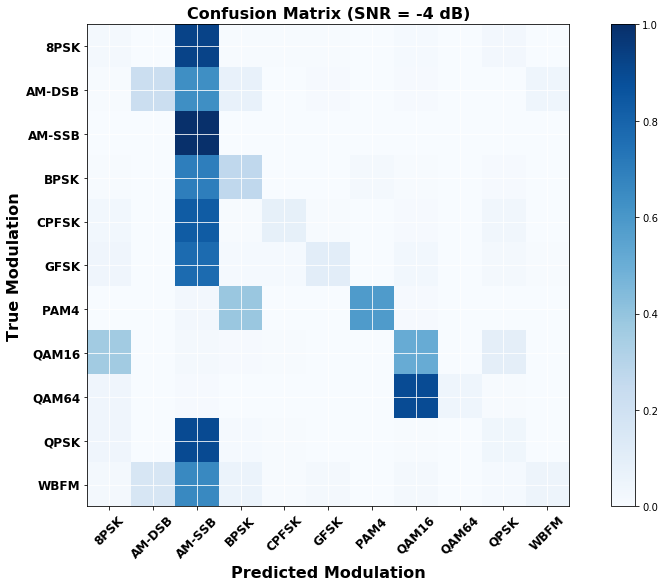

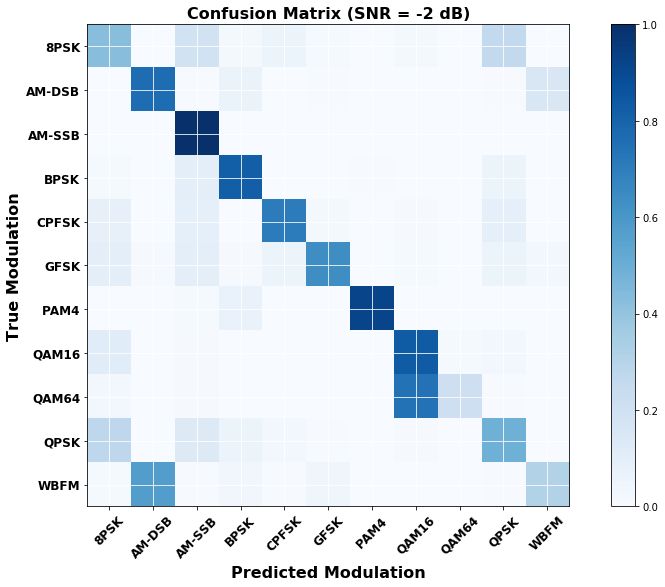

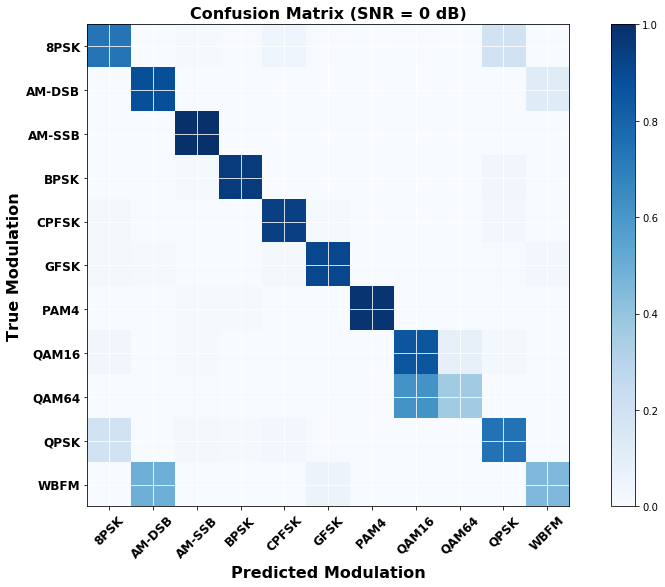

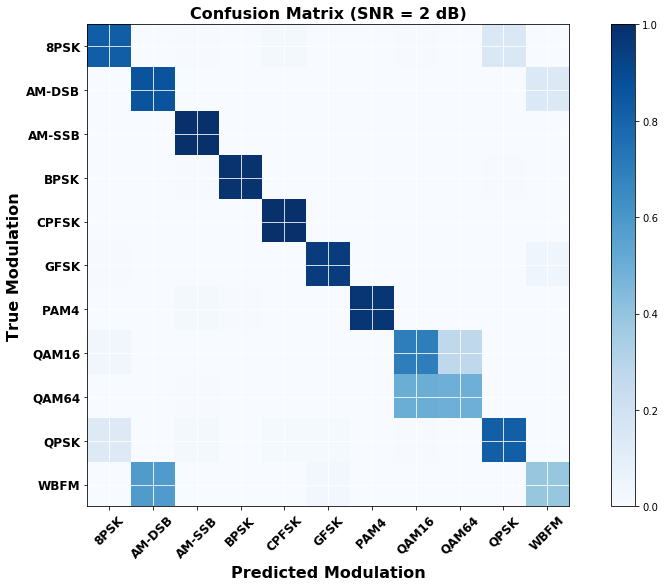

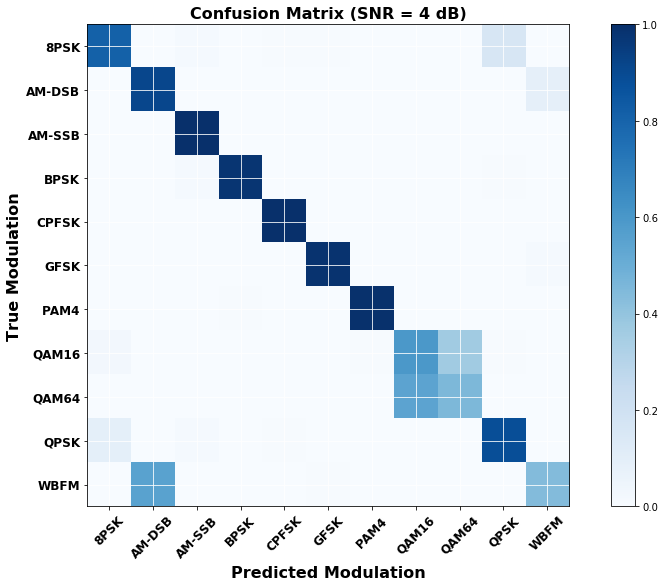

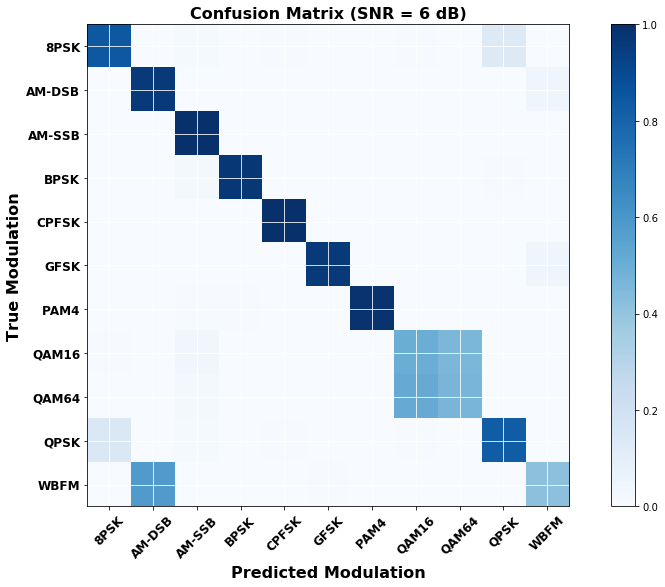

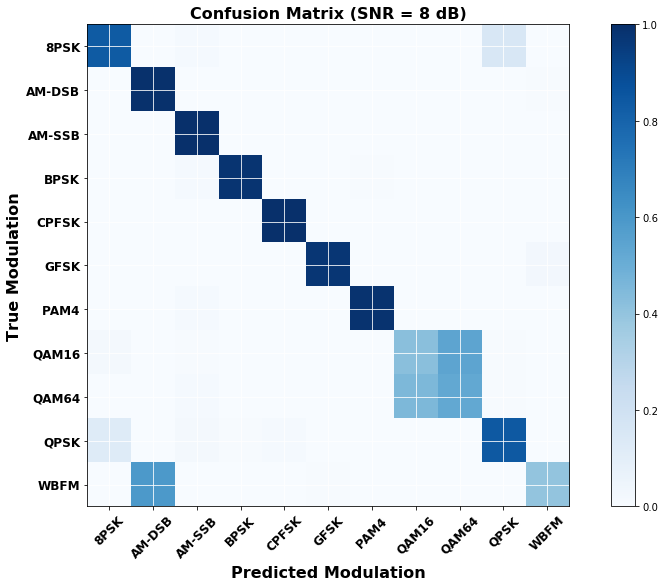

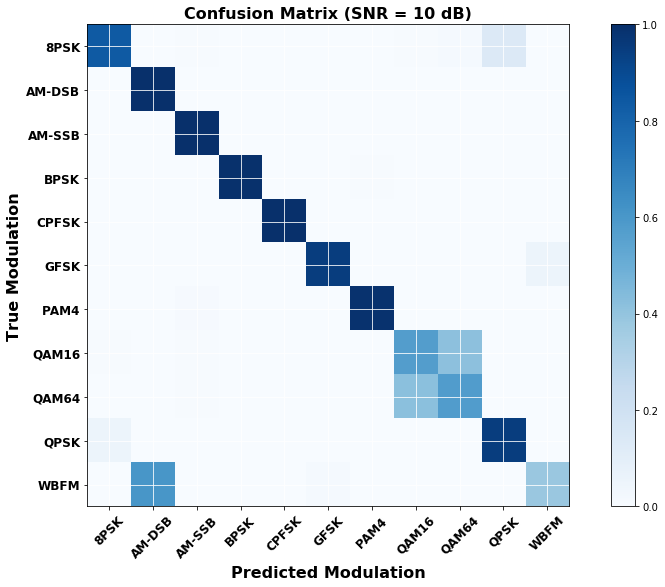

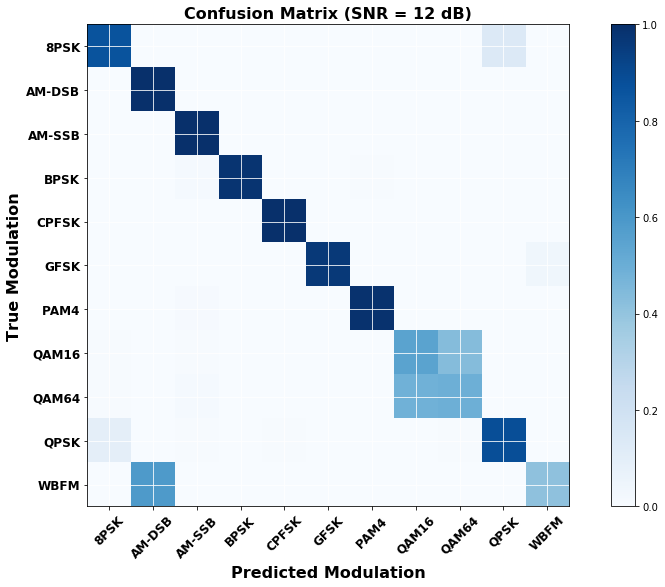

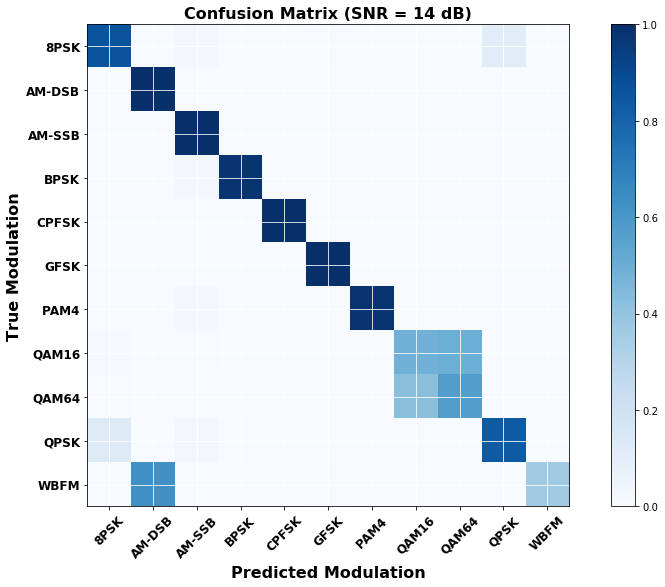

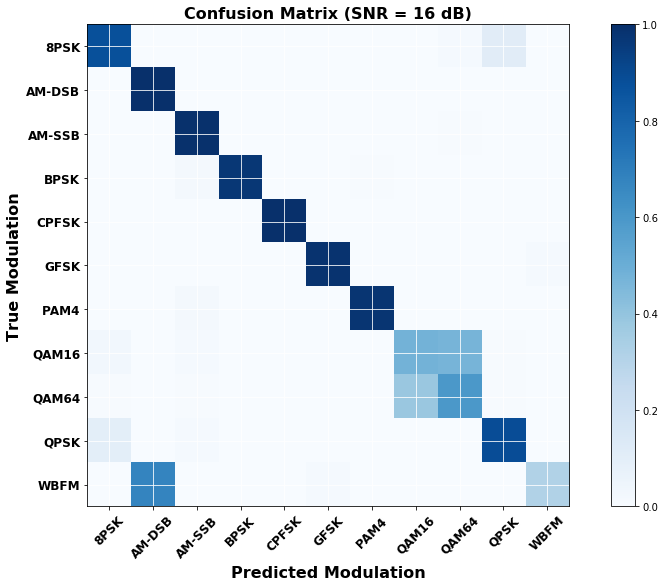

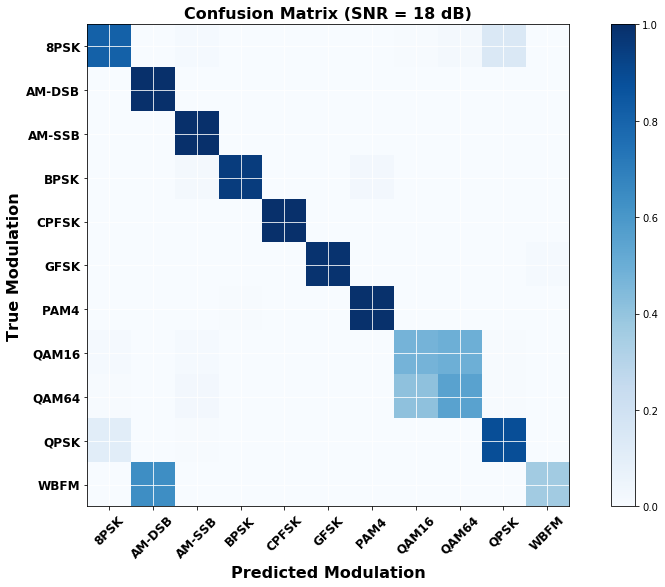

In [20]:
for snr_int in range(-20,20,2):
    snr_str = str(snr_int)
    plot_cm(confusion_pcts[snr_str], title="Confusion Matrix (SNR = %d dB)"%(snr_int), 
            filename="ConfMat_%ddB.png"%(snr_int))

## Create a dataframe with results of model with certain hyperparameters.

In [21]:
import pandas as pd

In [22]:
lr = [0.01, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.005, 0.001] #learning rate
opt = ["SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD"] #optimizer used
acc = [24.458, 24.587, 25.315, 24.500, 25.283, 24.932, 23.896, 24.552, 24.659, 25.220] #accuracy of all
dropout = ["yes, 1 layer 50%", "yes, 3 layers 50%", "yes, 3 layers 50%", "yes 3 layers 50%", "yes 3 layers 60%", "yes 3 layers 60%","yes 3 layers 70%", "yes 3 layers 70%","yes 3 layers 70%", "yes 3 layers 55%" ] #was dropout used?
ec = [25, 25, 100, 43, 100, 150, 100, 150, 100, 100] #epoch count

df = pd.DataFrame(list(zip(lr, opt, acc, dropout, ec)), columns =['Learning Rate', 'Optimizer', 'Accuracy', 'Dropout', 'Num Epochs'])


df.head(9)

,Learning Rate,Optimizer,Accuracy,Dropout,Num Epochs
0,0.010,SGD,24.458,"yes, 1 layer 50%",25
1,0.001,SGD,24.587,"yes, 3 layers 50%",25
2,0.001,SGD,25.315,"yes, 3 layers 50%",100
3,0.001,SGD,24.500,yes 3 layers 50%,43
4,0.001,SGD,25.283,yes 3 layers 60%,100
5,0.001,SGD,24.932,yes 3 layers 60%,150
6,0.001,SGD,23.896,yes 3 layers 70%,100
7,0.001,SGD,24.552,yes 3 layers 70%,150
8,0.005,SGD,24.659,yes 3 layers 70%,100


The motivation on line 3 for 43 epochs is because on line 2, the data started overfitting after 40ish epochs.


Conv layers are untouched.
Momentum = 0.9 for all of these.
SGD Optimizer for all of these.